<a href="https://colab.research.google.com/github/lepremiere/Data-Collection/blob/main/00_Tutorial/01_first_steps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Experiments: Matrix Multiplication**

In the following examples we will use matrix multiplications on **M** x **M** matrices with **M = {1, ..., N}**.

Instead of generating the matrices on each iteration, we will create a N x N matrix and draw a M x M sample from it.

While there is no real advantage by doing this for computations on the CPU, it helps to reduce the cross-communatication to a GPU. 

Before we do that, we need to install some dependencies.

**Installation**

To use either Numpy, Tensorflow or Torch we need to install those libraries first. Under Python we have a convenience function to handle it for us.
It is called Pip. The usage is very simple. You call Pip with the command "install" and the name of the module to install. 

Tensorflow additionally requires you to manually install the supported CUDA libraries yourself ([Installation Guide](https://www.tensorflow.org/install/gpu)).

Additionally, we will install a module to plot the results (matplotlib).

In [ ]:
!pip install numpy
!pip install tensorflow
!pip install torch
!pip install matplotlib

**Imports and Parameters**

To use the libraries we just installed, we need to import them.


In [ ]:
import numpy as np
import tensorflow as tf
import torch

import matplotlib.pyplot as plt
import timeit
import time

Helper methods

We create a function that helps us to evaluate the computation speed over matrix dimensions and a different one to plot the results.
Because it takes very long to iterate over high dimensions, especiall with the native implementation of the matrix multiplication, the eval function will also contain early stopping.

In [ ]:
def eval_method(method, AA, BB, M, n_sims, t_max):
  """
  Inputs:
    method: method that does matrix multiplication
    AA:     square matrix
    BB:     square matrix
    M:      dimensions to iterate over
    n_sims: number of simulations
    t_max:  early stopping
  Output:
    t:      mean time of execution
  """
  t = [0]
  for m in M:
    A = AA[0:m, 0:m]
    B = BB[0:m, 0:m]

    if t[-1] < t_max:
      t.append(timeit.timeit(
          lambda: method(A, B), 
          timer=time.perf_counter,
          number=n_sims)/n_sims)
    else:
      t.append(np.nan)
  t.pop(0)

  return t

def plot_results(D, t, names):
  plt.plot(D[5:], t[5:])
  plt.ylabel("s")
  plt.xlabel("m")
  plt.title("Runtime Analysis")
  plt.legend(names)
  plt.show()

In [ ]:
# Parameters
N = 1000
M = np.arange(1, N)

**Native**

The first experiment will use a native implementation of the matrix multiplication. Since it does not come out of the box, we need to implement it ourselves.

In [ ]:
# method definition
def matmul(A, B):
    n, m = np.shape(A)
    C = np.zeros((n, n), dtype=np.int32)

    for i in range(n):
        for k in range(n):
            for j in range(m):
                C[i][k] += A[i][j] * B[j][k]
    return C

Create matrices

In [ ]:
AA = np.random.uniform(0, 10, (N, N))
BB = np.random.uniform(0, 10, (N, N))

Evaluation

To compare the results between methods, we will also store the timings in local lists.

Native: 166.65611743927002 s


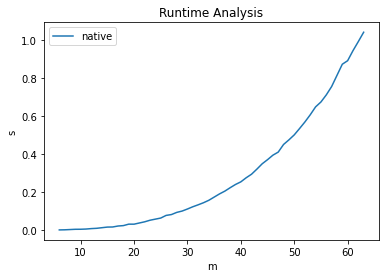

In [ ]:
t0 = time.time()
t_native = eval_method(matmul, AA, BB, M, 10, 1)
print(f"Native: {time.time()-t0} s")
plot_results(M, t_native, ["native"])

As we can see, the function runs in polynomial time. This can be expected, since we loop over n 3 times. O(n^3)

**Numpy**

Next we have a library optimzed for numerical computations, hence the name. The method "np.matmul" is now the next target.

Numpy: 154.85624170303345 s


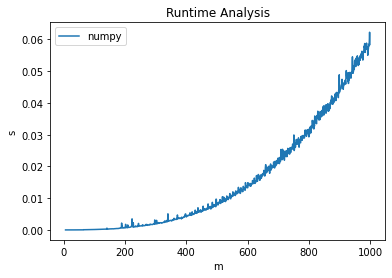

In [ ]:
t0 = time.time()
t_numpy = eval_method(np.matmul, AA, BB, M, 10, 0.1)
print(f"Numpy: {time.time()-t0} s")
plot_results(M, t_numpy, ["numpy"])

As we can see, also numpy runs in polynomial time, but because it vectorizes the computations, we will drop a magnitude in time complexity. O(n^2)


**Tensorflow**

The method "tf.matmul" is now the next target.
Tensorflow will automatically compute on a GPU if present.
To check wether it is, we can ask tensorflow to show us all GPU devices it can access.

**Note**: If you are running the notebook in CoLab, you need to active an GPU-accelerator. You can achieve this by navigating to "Runtime/Change Runtime type" and select "GPU" or "TPU" (another form of GPU specialized on tensors).

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In this run we will use the numpy arrays we created earlier. This will cause some dramatic latency, since the array needs to be converted and sent to the GPU.

Tensorflow: 23.978986501693726 s


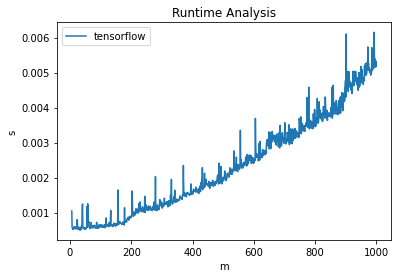

In [ ]:
t0 = time.time()
t_tf_0 = eval_method(tf.matmul, AA, BB, M, 10, 1)
print(f"Tensorflow: {time.time()-t0} s")
plot_results(M, t_tf_0, ["tensorflow"])

The time complexity remains polynomial O(n^2), although beeing faster itself. 
Instead we can also create the array directly on the GPU and draw from it. To achieve that, we create Tensor arrays directly by just calling tensorflow instead of numpy. Additionally, we set the scope to the GPU, so tensorflow puts the array directly to it.

Tensorflow: 2.6253061294555664 s


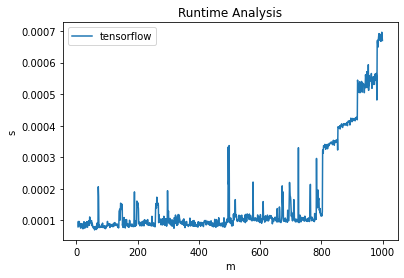

In [ ]:
with tf.device("/gpu:0"):
  AA_tf = tf.random.uniform((N, N), 0, 1)
  BB_tf = tf.random.uniform((N, N), 0, 1)

t0 = time.time()
t_tf_1 = eval_method(tf.matmul, AA_tf, BB_tf, M, 10, 0.2)
print(f"Tensorflow: {time.time()-t0} s")
plot_results(M, t_tf_1, ["tensorflow"])

We could achieve a better performance increase, due to lower overhead. We see a change in time complexity from O(1) to approx. O(n). This may be due to batching of a matrix that is to big for the GPU cache.

**PyTorch**

Lastly, we are taking a look at pytorch. This library also uses CUDA but is optimized for python specifically, which makes it more comprehensive than tensorflow, at least for a pythonist.

PyTorch requires us to input Tensors into their functions. Therefore we need to convert/create our inital arrays.

PyTorch: 71.13426160812378 s


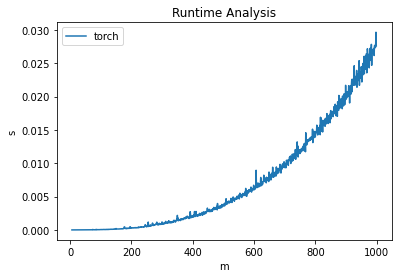

In [ ]:
AA_torch = torch.rand((N, N))
BB_torch = torch.rand((N, N))

t0 = time.time()
t_torch_0 = eval_method(torch.matmul, AA_torch, BB_torch, M, 10, 0.2)
print(f"PyTorch: {time.time()-t0} s")
plot_results(M, t_torch_0, ["torch"])

The time complexity remains polynomial O(n^2), although beeing faster itself. 
As with tensorflow, we can also reduce the runtime by specifically create variable on the GPU itself. Under pytorch we can achieve that by calling the ".gpu()" method of a torch array. To get the array back to CPU we can call ".cpu()".

PyTorch: 2.144343376159668 s


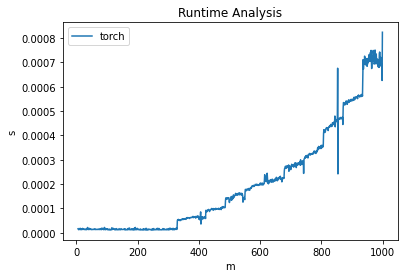

In [ ]:
AA_torch = torch.rand((N, N)).cuda()
BB_torch = torch.rand((N, N)).cuda()

t0 = time.time()
t_torch_1 = eval_method(torch.matmul, AA_torch, BB_torch, M, 10, 0.2)
print(f"PyTorch: {time.time()-t0} s")
plot_results(M, t_torch_1, ["torch"])

We could achieve a better performance increase, due to lower overhead. As in numpy we see a change in time complexity from O(1) to polynomial time. This may be due to batching of a matrix that is to big for the GPU cache.

**Comparison**

Let us see how the methods compare.

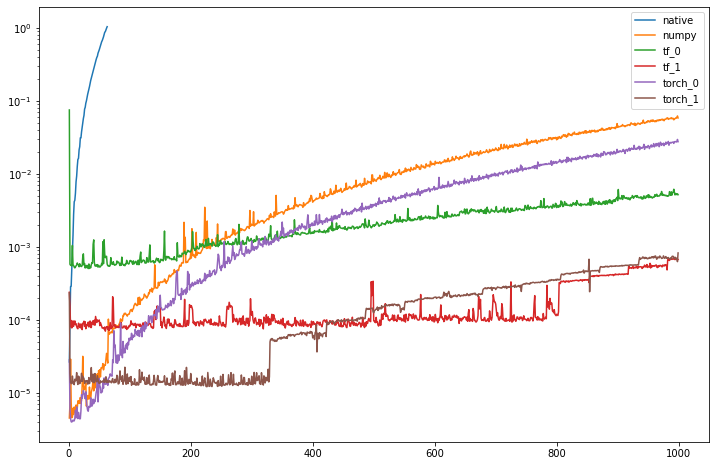

In [ ]:
fig = plt.figure(figsize=(12, 8))
for t in [t_native, t_numpy, t_tf_0, t_tf_1, t_torch_0, t_torch_1]:
  plt.plot(M, t)
plt.yscale("log")
plt.legend(["native", "numpy", "tf_0", "tf_1", "torch_0", "torch_1"])
plt.show()


**Conclusion**

Libraries that vectorize operations can help to dramatically reduce the runtime of our algorithmns. 

**Note**: Depending on your operating system, CPU and GPU, these results may vary a great deal. Also, you do not specifically call the "[backend].matmul()" method. Instead a "@" also does the trick (see below).


**Playground**

Congrats! You made it through. Now let us spend some time to see the sheer power of GPU computations when it comes to matrix multiplications. We will use a slightly larger matrix for this. 

In [ ]:
N = 10000
with tf.device("/gpu:0"):
  AA_tf = tf.random.uniform((N, N), 0, 1)
  BB_tf = tf.random.uniform((N, N), 0, 1)

t0 = time.time()
AA_tf @ BB_tf
print(f"Tensorflow, N = {N}, t = {time.time()-t0}")

Tensorflow, N = 10000, t = 0.01770305633544922


In [ ]:
N = 10000
AA_torch = torch.rand((N, N)).cuda()
BB_torch = torch.rand((N, N)).cuda()

t0 = time.time()
AA_torch @ AA_torch
print(f"PyTorch, N = {N}, t = {time.time()-t0}")

PyTorch, N = 10000, t = 0.001302480697631836
